In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
sns.set_style("darkgrid")
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [27]:
df_res = pd.read_csv('/content/drive/MyDrive/crm/Retail_Data_Response.csv') 
df_txn = pd.read_csv('/content/drive/MyDrive/crm/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [28]:
df_res.head(5)

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [29]:
df_txn.head(5)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [30]:
print(df_txn['trans_date'].max())
print(df_txn['trans_date'].min())

2015-03-16 00:00:00
2011-05-16 00:00:00


In [31]:
df_txn['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

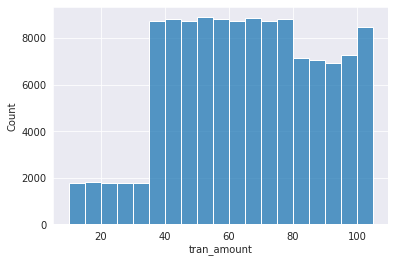

In [32]:
sns.histplot(data=df_txn, x="tran_amount", binwidth=5)

In [44]:
response_rate = df_res.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.rename(columns={'customer_id': 'no_cust'}, inplace=True)
response_rate.head()

,response,no_cust
0,0,6237
1,1,647


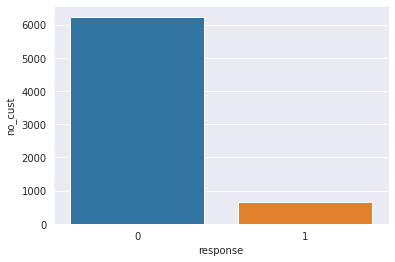

In [46]:
sns.barplot(x="response", y="no_cust", data=response_rate)

In [33]:
campaign_date = dt.datetime(2015,3,17)

df_txn['recent'] = (campaign_date - df_txn['trans_date']).dt.days
df_txn.head(5)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764
1,CS4768,2015-03-15,39,2
2,CS2122,2013-02-26,52,749
3,CS1217,2011-11-16,99,1217
4,CS1850,2013-11-20,78,482


In [34]:
df_txn['size_s'] =  df_txn['tran_amount'].apply(lambda x : 1 if x <= 35 else 0  )
df_txn['size_m'] =  df_txn['tran_amount'].apply(lambda x :  1 if x > 35 and x < 80 else 0 )
df_txn['size_l'] =  df_txn['tran_amount'].apply(lambda x : 1 if x > 80 else 0) 
df_txn.head(5)

,customer_id,trans_date,tran_amount,recent,size_s,size_m,size_l
0,CS5295,2013-02-11,35,764,1,0,0
1,CS4768,2015-03-15,39,2,0,1,0
2,CS2122,2013-02-26,52,749,0,1,0
3,CS1217,2011-11-16,99,1217,0,0,1
4,CS1850,2013-11-20,78,482,0,1,0


In [37]:
df_rfm = df_txn.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                            'customer_id': lambda x: len(x),                 # Frequency
                                            'tran_amount': lambda x: x.sum(),                # Monetary Value
                                            'size_s' : lambda x: x.sum(),
                                            'size_m': lambda x: x.sum(),
                                            'size_l' : lambda x: x.sum(),})

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)
df_rfm.head(5)

,recency,frequency,monetary_value,size_s,size_m,size_l
customer_id,,,,,,
CS1112,62,15,1012,0,11,4
CS1113,36,20,1490,0,10,10
CS1114,33,19,1432,0,10,9
CS1115,12,22,1659,0,13,9
CS1116,204,13,857,0,8,4


In [38]:
df_rfm = df_rfm.reset_index()
df_rfm.head(5)

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l
0,CS1112,62,15,1012,0,11,4
1,CS1113,36,20,1490,0,10,10
2,CS1114,33,19,1432,0,10,9
3,CS1115,12,22,1659,0,13,9
4,CS1116,204,13,857,0,8,4


In [39]:
df_rfm['ticket_size'] = df_rfm['monetary_value'] / df_rfm['frequency']
df_rfm.head(5)

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,ticket_size
0,CS1112,62,15,1012,0,11,4,67.466667
1,CS1113,36,20,1490,0,10,10,74.500000
2,CS1114,33,19,1432,0,10,9,75.368421
3,CS1115,12,22,1659,0,13,9,75.409091
4,CS1116,204,13,857,0,8,4,65.923077


In [47]:
df_modeling =  pd.merge(df_rfm,df_res)
df_modeling.head(5)

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,ticket_size,response
0,CS1112,62,15,1012,0,11,4,67.466667,0
1,CS1113,36,20,1490,0,10,10,74.500000,0
2,CS1114,33,19,1432,0,10,9,75.368421,1
3,CS1115,12,22,1659,0,13,9,75.409091,1
4,CS1116,204,13,857,0,8,4,65.923077,1


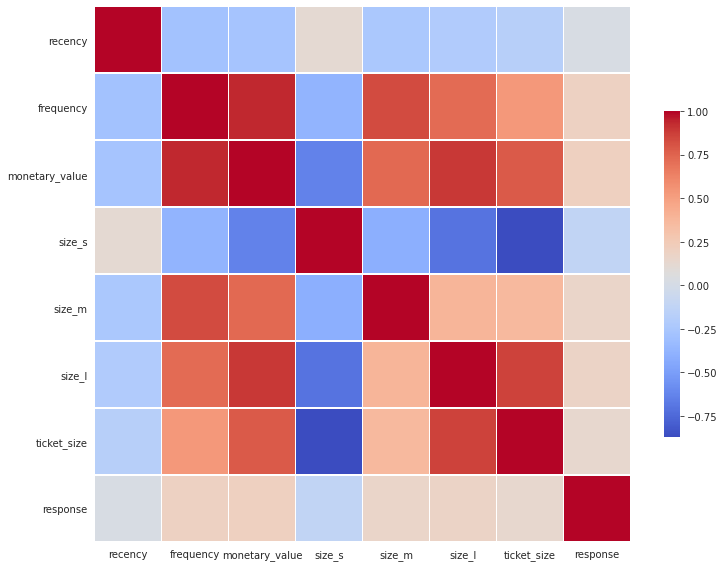

In [49]:
corr = df_modeling.corr()

f, axes = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, cmap=cmap,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [50]:
X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 7)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 7)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

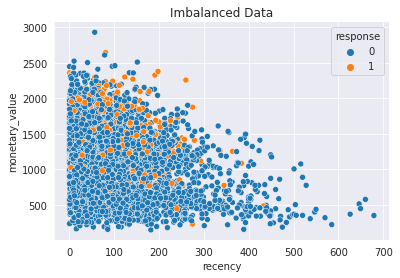

In [52]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

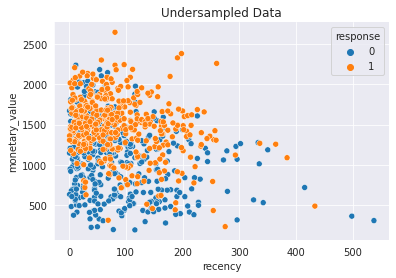

In [54]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency',	'frequency',	'monetary_value',	'size_s',	'size_m',	'size_l',	'ticket_size',	'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

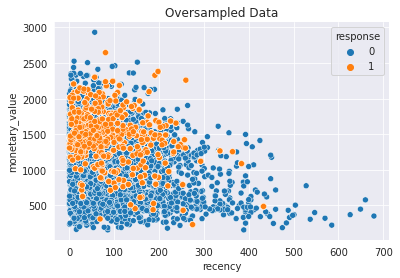

In [55]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency',	'frequency',	'monetary_value',	'size_s',	'size_m',	'size_l',	'ticket_size',	'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

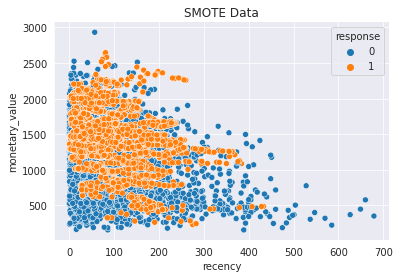

In [57]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency',	'frequency',	'monetary_value',	'size_s',	'size_m',	'size_l',	'ticket_size',	'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [58]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       429
           1       0.65      0.72      0.68       429

    accuracy                           0.67       858
   macro avg       0.67      0.67      0.67       858
weighted avg       0.67      0.67      0.67       858

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.62      2066
   macro avg       0.56      0.66      0.52      2066
weighted avg       0.87      0.62      0.70      2066



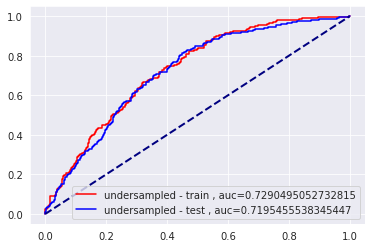

In [59]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [60]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00393808 -0.08493382  0.00341189 -0.12931059 -0.00061715  0.01254193
  -0.04340108]] [-0.19673119]


In [61]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      4389
           1       0.65      0.70      0.67      4389

    accuracy                           0.66      8778
   macro avg       0.66      0.66      0.66      8778
weighted avg       0.66      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.70      0.28       218

    accuracy                           0.63      2066
   macro avg       0.56      0.66      0.52      2066
weighted avg       0.86      0.63      0.70      2066



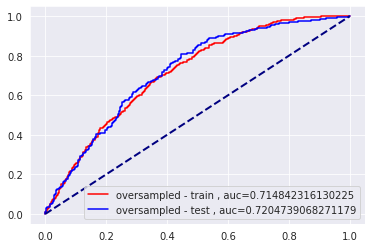

In [62]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [63]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.0038632  -0.05060635  0.00344322 -0.14450984 -0.03186283 -0.05449029
  -0.03912956]] [-0.19673119]


In [64]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      4389
           1       0.65      0.72      0.68      4389

    accuracy                           0.66      8778
   macro avg       0.66      0.66      0.66      8778
weighted avg       0.66      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.70      0.28       218

    accuracy                           0.63      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.86      0.63      0.70      2066



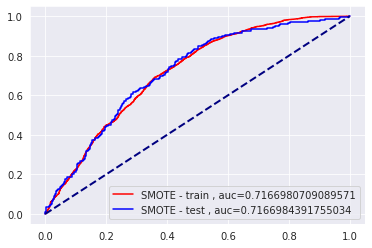

In [65]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [66]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.0034109  -0.14043184  0.00421186 -0.12005774  0.01600467 -0.03665536
  -0.0432081 ]] [-0.19673119]


In [67]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.705378
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713196
[2]	validation_0-auc:0.710194
[3]	validation_0-auc:0.71163
[4]	validation_0-auc:0.712873
[5]	validation_0-auc:0.715578
[6]	validation_0-auc:0.712991
[7]	validation_0-auc:0.714885
[8]	validation_0-auc:0.716037
[9]	validation_0-auc:0.716667
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.72274
[12]	validation_0-auc:0.72587
[13]	validation_0-auc:0.727366
[14]	validation_0-auc:0.729031
[15]	validation_0-auc:0.727198
[16]	validation_0-auc:0.725661
[17]	validation_0-auc:0.724891
[18]	validation_0-auc:0.725011
[19]	validation_0-auc:0.725433
Stopping. Best iteration:
[14]	validation_0-auc:0.729031

training set
              precision    recall  f1-score   support

           0       0.77      0.57      0.66       429
           1       0.66      0.83      0.74       429

    accuracy                           0.70       858
   macro avg 

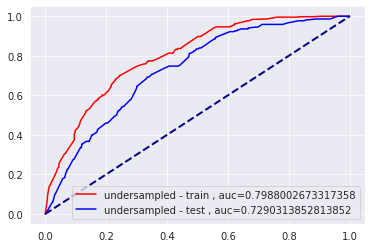

In [68]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

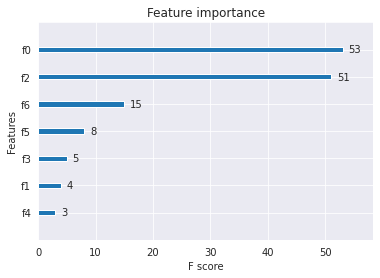

In [69]:
xgb.plot_importance(xgb_model_under)

In [70]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.71776
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.729193
[2]	validation_0-auc:0.730322
[3]	validation_0-auc:0.731383
[4]	validation_0-auc:0.730898
[5]	validation_0-auc:0.732849
[6]	validation_0-auc:0.733393
[7]	validation_0-auc:0.733275
[8]	validation_0-auc:0.733862
[9]	validation_0-auc:0.734654
[10]	validation_0-auc:0.734117
[11]	validation_0-auc:0.735333
[12]	validation_0-auc:0.734784
[13]	validation_0-auc:0.733503
[14]	validation_0-auc:0.73547
[15]	validation_0-auc:0.737416
[16]	validation_0-auc:0.737727
[17]	validation_0-auc:0.737454
[18]	validation_0-auc:0.737396
[19]	validation_0-auc:0.737914
[20]	validation_0-auc:0.737603
[21]	validation_0-auc:0.737287
[22]	validation_0-auc:0.737416
[23]	validation_0-auc:0.738078
[24]	validation_0-auc:0.73743
[25]	validation_0-auc:0.737063
[26]	validation_0-auc:0.737775
[27]	validation_0-auc:0.738013
[28]	validation_0-auc:0.738681
[29]	validation_0-auc:0

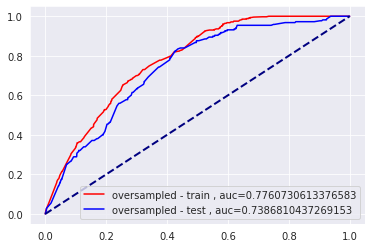

In [71]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

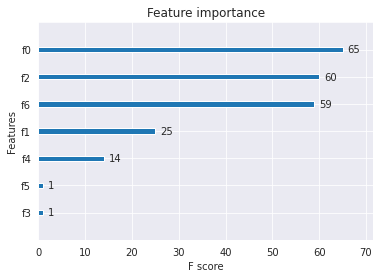

In [72]:
xgb.plot_importance(xgb_model_over)

In [76]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.676032
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.689588
[2]	validation_0-auc:0.688847
[3]	validation_0-auc:0.684283
[4]	validation_0-auc:0.686407
[5]	validation_0-auc:0.683962
[6]	validation_0-auc:0.698692
[7]	validation_0-auc:0.699989
[8]	validation_0-auc:0.695531
[9]	validation_0-auc:0.696643
[10]	validation_0-auc:0.695036
[11]	validation_0-auc:0.697884
[12]	validation_0-auc:0.694067
Stopping. Best iteration:
[7]	validation_0-auc:0.699989

training set
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      4389
           1       0.71      0.85      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.66      0.7

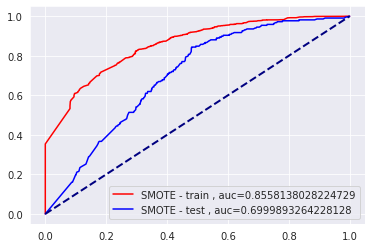

In [81]:
y_score_train = xgb_model_SMOTE_tuned.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_tuned.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

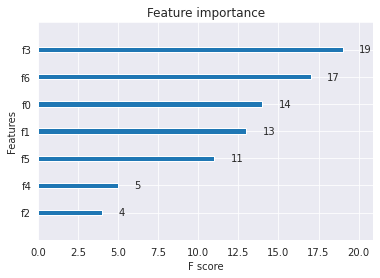

In [79]:
xgb.plot_importance(xgb_model_SMOTE_tuned)